# Решение задачи регрессии IC50

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Пример моделей для сравнения
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge

from tqdm import tqdm

In [2]:
Random_seed = 42
# Задаем seed
np.random.seed(Random_seed)

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Python/Курсовая Классическое МО/Обработанные данные.xlsx')

In [4]:
target = 'log IC50'
drop = ['log CC50', 'log SI', 'IC50, mM', 'CC50, mM', 'SI']

target_df = df.drop(columns=drop)

In [5]:
# Загрузка данных
X = target_df.drop(columns=[target])
y = target_df[target]

In [6]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Определяем параметры для GridSearch по каждой модели
model_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
        }
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1],
            'max_iter': [1000, 5000]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'k-Nearest Neighbors': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'Kernel Ridge': {
        'model': KernelRidge(),
        'params': {
            'alpha': [0.1, 1.0],
            'kernel': ['linear', 'rbf']
        }
    }
}


In [9]:
# Функция для вычисления и вывода метрик
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return {'Model': model_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}


In [10]:
# Словарь для хранения обученных моделей
trained_models = {}

# Переменная для хранения результатов
results = []

# Поиск лучших параметров и оценка для каждой модели
for model_name, mp in model_params.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")

    # Инициализация GridSearchCV
    grid = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    # Обучение модели
    grid.fit(X_train, y_train)

    # Сохраняем модель в словарь
    trained_models[model_name] = {
        'model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_score': -grid.best_score_
    }

    # Предсказание на тестовых данных
    y_pred = grid.predict(X_test)

    # Вычисление метрик
    model_metrics = evaluate_model(y_test, y_pred, model_name)

    # Сохранение результатов
    results.append({
        **model_metrics,
        'Best Params': grid.best_params_,
        'Best Score': -grid.best_score_
    })

    print(f"Best parameters: {grid.best_params_}")


Training Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Linear Regression Metrics:
MAE: 1.5001
MSE: 3.7879
RMSE: 1.9463
R2 Score: 0.2829
Best parameters: {'fit_intercept': True}

Training Ridge Regression...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Ridge Regression Metrics:
MAE: 1.5266
MSE: 4.2576
RMSE: 2.0634
R2 Score: 0.1940
Best parameters: {'alpha': 0.1, 'solver': 'svd'}

Training Lasso Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e+03, tolerance: 3.625e-01
  model = cd_fast.enet_coordinate_descent(



Lasso Regression Metrics:
MAE: 1.5193
MSE: 4.1702
RMSE: 2.0421
R2 Score: 0.2105
Best parameters: {'alpha': 0.001, 'max_iter': 5000}

Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Random Forest Metrics:
MAE: 1.2737
MSE: 2.6262
RMSE: 1.6206
R2 Score: 0.5028
Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Training Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Gradient Boosting Metrics:
MAE: 1.2991
MSE: 2.6994
RMSE: 1.6430
R2 Score: 0.4889
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Training k-Nearest Neighbors...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

k-Nearest Neighbors Metrics:
MAE: 1.5268
MSE: 3.9716
RMSE: 1.9929
R2 Score: 0.2481
Best parameters: {'n_neighbors': 7, 'weights': 'distance'}

Training Kernel Ridge...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Kernel Ridge Metrics:
MAE: 3.4529
MSE: 16.2660
R

In [11]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE')

# Выводим итоговую таблицу сравнения моделей
print("\n\n=== Final Results ===")
results_df[['Model', 'RMSE', 'R2', 'Best Params']]



=== Final Results ===


,Model,RMSE,R2,Best Params
3,Random Forest,1.620564,0.502802,"{'max_depth': 10, 'min_samples_split': 5, 'n_e..."
4,Gradient Boosting,1.642999,0.488941,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
0,Linear Regression,1.946263,0.282867,{'fit_intercept': True}
5,k-Nearest Neighbors,1.992879,0.248102,"{'n_neighbors': 7, 'weights': 'distance'}"
2,Lasso Regression,2.042105,0.210498,"{'alpha': 0.001, 'max_iter': 5000}"
1,Ridge Regression,2.063394,0.193952,"{'alpha': 0.1, 'solver': 'svd'}"
6,Kernel Ridge,4.033108,-2.079473,"{'alpha': 0.1, 'kernel': 'rbf'}"


In [12]:
# Находим модель с наименьшим RMSE (лучшую модель)
best_result = results_df.iloc[0]
best_model_name = best_result['Model']
best_model_info = trained_models[best_model_name]

print("\n" + "="*50)
print(f"Лучшая модель: {best_model_name}")
print("="*50)

# Выводим метрики лучшей модели
print("\nЛучшие метрики:")
print(f"- RMSE: {best_result['RMSE']:.4f}")
print(f"- R2: {best_result['R2']:.4f}")
print(f"- MAE: {best_result['MAE']:.4f}")
print(f"- MSE: {best_result['MSE']:.4f}")


Лучшая модель: Random Forest

Лучшие метрики:
- RMSE: 1.6206
- R2: 0.5028
- MAE: 1.2737
- MSE: 2.6262


/tmp/ipython-input-13-3922683432.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


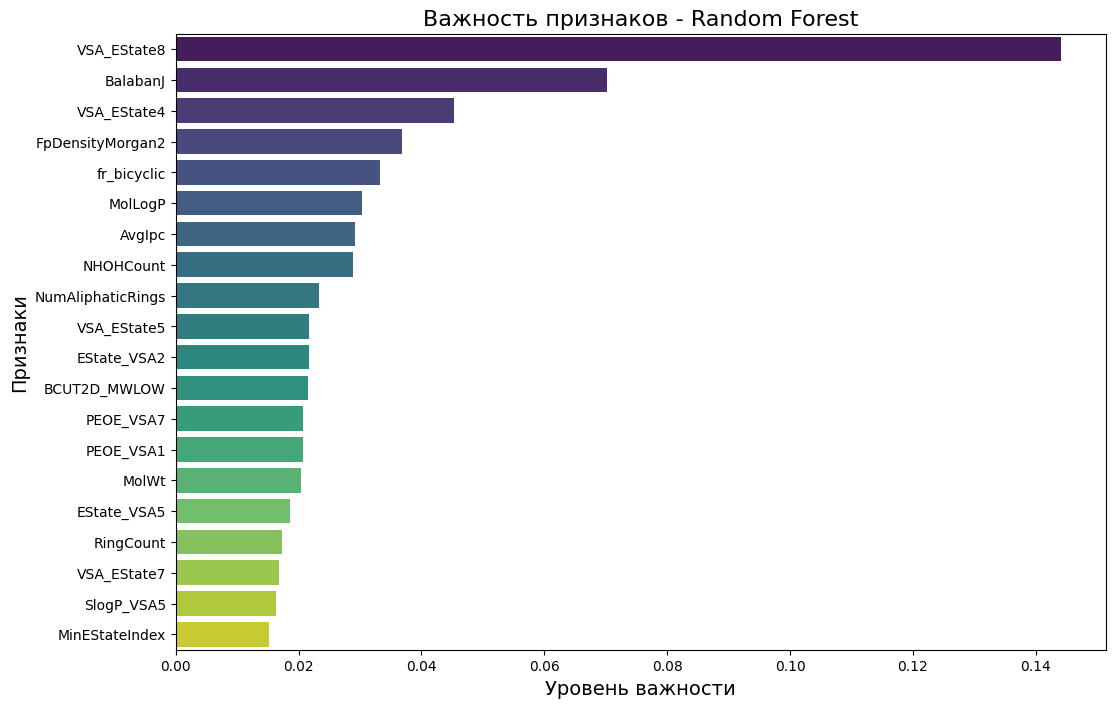

In [13]:
# Визуализируем важность признаков для лучшей модели
# Получаем важность признаков
feature_importance = best_model_info['model'].feature_importances_

# Создаем DataFrame для визуализации
features_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False)

# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Важность',
    y='Признак',
    data=features_df.head(20),
    palette='viridis'
)
plt.title(f'Важность признаков - {best_model_name}', fontsize=16)
plt.xlabel('Уровень важности', fontsize=14)
plt.ylabel('Признаки', fontsize=14)
plt.show()
